# CMSC 636, HW4: Deep Belief Network on MNIST

In [47]:
import numpy as np
import tensorflow as tf
from types import SimpleNamespace

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

## Load MNIST

In [48]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

## Model definition

In [49]:
sess = tf.InteractiveSession()

In [50]:
def bernoulli_sample_tf(x):
    ''' sample from bernoulli distribution given a tf matrix '''
    in_shape= x.get_shape().as_list()
    uniform_samp = tf.random_uniform(shape=(in_shape[0], in_shape[1]), minval=0.0, maxval=1.0) 
    return tf.to_float(tf.greater(x, uniform_samp))

Implement the contrastive divergence update rule for the rbm, using a mini-batch of  𝑀  samples:

𝑊←𝑊+𝛼Δ𝑊  
𝑏←𝑏+𝛼Δ𝑏  
𝑐←𝑐+𝛼Δ𝑐  

Where:

𝑊∈×,b∈,c∈  

𝑋∈×  , is the matrix composed by the training samples in the mini-batch. Each row of  𝑋  is a training sample 

Δ𝑊=1𝑀(𝑋𝑇ℎ(𝑥)−𝑋𝑇𝑠ℎ(𝑋𝑠))  

Δ𝑏=𝑚𝑒𝑎𝑛((ℎ(𝑋)−ℎ(𝑋𝑠)))  

Δ𝑐=𝑚𝑒𝑎𝑛((𝑋−𝑋𝑠))  

ℎ(𝑋)=𝜎(𝑋𝑊+𝑏);𝜎(𝑥)=11+exp(−𝑥) 
Note: The model uses Bernoulli visible and hidden layers

In [51]:
# Complete the following function using the code from the hw4_rbm script 
def rbm_model(X, W, b, c, k, alpha):
    # K gibbs sampling
    Xs = X;
    for i in range(k):
        hs_prob = tf.sigmoid(tf.matmul(Xs, W) + b)
        hs = bernoulli_sample_tf(hs_prob)
        Xs_prob = tf.sigmoid(tf.matmul(hs, tf.transpose(W)) + c)
        Xs = bernoulli_sample_tf(Xs_prob)

    # Parameter update:
    h_x =   tf.sigmoid(tf.matmul(X,W) + b)# Complete: compute h(X)
    h_xs =  tf.sigmoid(tf.matmul(Xs,W) + b)# Complete: compute h(Xs)

    dW = 1/batch_size * (tf.matmul(tf.transpose(X),h_x) - tf.matmul(tf.transpose(Xs),h_xs))# Complete: follow update equations

    db = 1/k * (h_x - h_xs)# Complete: follow update equations
    dc = 1/k * (X - Xs)  # Complete: follow update equations

    op_W= W.assign_add( alpha*dW )
    op_b= b.assign_add( alpha*db )
    op_c= c.assign_add( alpha*dc )

    update_weights = tf.group( op_W, op_b, op_c )
    
    return update_weights, Xs_prob, h_x, h_xs

In [52]:
n_inputs= 28*28         # Complete: number of input units (i.e. V)
n_hidden= [100, 20]     # number of hidden units (i.e. H), try different values
batch_size= 500         # number of samples on the mini-batch (i.e. M)

k= 5       #Try different values

X = tf.placeholder( tf.float32, shape=(batch_size, n_inputs))

# Definition of first RBM model
W1= tf.Variable(tf.zeros([n_inputs, n_hidden[0]]))# Complete: weight matrix for the rbm model on the first layer
b1= tf.Variable(tf.zeros([batch_size, n_hidden[0]]))# Complete: b vector for the rbm model on the first layer
c1= tf.Variable(tf.zeros([batch_size, n_inputs]))# Complete: c vector for the rbm model on the first layer

alpha= 0.1  #Try different values
alpha = 2
update_weights1, Xs_prob, h1_x, h1_xs = rbm_model( X, W1, b1, c1, k, alpha )

# Definition of second RBM model 
W2= tf.Variable(tf.zeros([n_hidden[0], n_hidden[1]]))# Complete: weight matrix for the rbm model of the second layer
b2= tf.Variable(tf.zeros([batch_size, n_hidden[1]]))# Complete: b vector for the rbm model on the second layer
c2= tf.Variable(tf.zeros([batch_size, n_hidden[0]]))# Complete: c vector for the rbm model on the second layer

alpha= 0.1 #Try different values
alpha = 2
update_weights2, h1s_prob, h2_h1, h2_h1s = rbm_model( h1_x, W2, b2, c2, k, alpha )

## Sampling

In [53]:
Xs_prob_h2 = tf.sigmoid(tf.matmul(h1s_prob, tf.transpose(W1)) + c1) # samples given X while training second RBM

# random samples from DBN model starting with random h1 samples
h1st = tf.random_uniform(shape=(batch_size, n_hidden[0]), minval=0, maxval=1)
for i in range(10):
    Xst_prob = tf.sigmoid(tf.matmul(h1st, tf.transpose(W1)) + c1)
    Xst = bernoulli_sample_tf(Xst_prob)
    h1st_prob = tf.sigmoid(tf.matmul(Xst, W1) + b1)
    h1st = bernoulli_sample_tf(h1st_prob)
Xst_prob_h1st = tf.sigmoid(tf.matmul(h1st, tf.transpose(W1)) + c1) # X generated from random h1


# random samples from DBN model starting with random h2 samples
h2st = tf.random_uniform(shape=(batch_size, n_hidden[1]), minval=0, maxval=1)
for i in range(10):
    h1st_prob = tf.sigmoid(tf.matmul(h2st, tf.transpose(W2)) + c2)
    h1st = bernoulli_sample_tf(h1st_prob)
    h2st_prob = tf.sigmoid(tf.matmul(h1st, W2) + b2)
    h2st = bernoulli_sample_tf(h2st_prob)
Xst_prob_h2st = tf.sigmoid(tf.matmul(h1st, tf.transpose(W1)) + c1) # X generated from random h2

## Training

In [54]:
init = tf.global_variables_initializer()
sess.run(init)
print('Initialized')

Initialized


### Training of layer 1 (first RBM)

Samples generated starting from given X


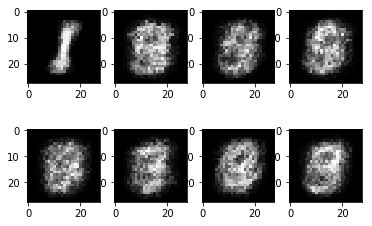

Samples generated from random H1


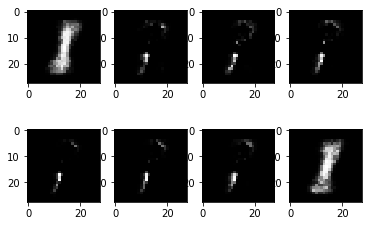

KeyboardInterrupt: 

In [55]:
num_steps= 10000 # try different values
n_logging = 500  # try different values

for step in range(num_steps):
    # -------- train RBM -----#
    batch_x, _= mnist.train.next_batch(batch_size) 
    [_, x_g] = sess.run([update_weights1, Xs_prob], feed_dict= {X : batch_x})
    
    #  ------- logging -------
    if step%n_logging == 0:
        clear_output()
        print('Samples generated starting from given X')
        
        x_gaux = np.reshape(x_g, [-1,28,28,1])        
        plt.figure(1)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()
        
        print('Samples generated from random H1')
        [x_g] = sess.run([Xst_prob_h1st], feed_dict= {X : batch_x})
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(2)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()

Training of layer 2 (second RBM)

In [ ]:
num_steps= 10000 # try different values
n_logging = 500  # try different values

for step in range(num_steps):
    # -------- train RBM -----#
    batch_x, _= mnist.train.next_batch(batch_size) 
    [_, x_g] = sess.run([update_weights2, Xs_prob_h2], feed_dict= {X : batch_x})
    
    #  ------- logging -------
    if step%n_logging == 0:
        clear_output()
        print('Samples generated starting from given X')
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(1)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()
        
        print('Samples generated from random H2')
        [x_g] = sess.run([Xst_prob_h2st], feed_dict= {X : batch_x})
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(2)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()